#LOW-LIGHT + NUCLEAR NORM

## Oscar Miguel Ortega Lozano - 2220528


## Daniel Esteban Yaruro Contreras - 2220088


## Juan David Toloza Parada - 2221136

---
## Problema de Imagen en Condiciones de Baja Iluminación (Low-Light) usando ADMM con Regularización por Norma Nuclear

Este notebook presenta una implementación del algoritmo **ADMM (Alternating Direction Method of Multipliers)** para resolver un problema de mejora de imagen en condiciones de **baja iluminación**. Se modela el ruido como una distribución de **Poisson**, y se usa la **norma nuclear** como prior para regularización.

---

### 1. Formulación del problema

Dado:
- Imagen observada $y$ con ruido tipo Poisson.
- Imagen original desconocida $x$.

Modelo probabilístico:
$$
y \sim \mathcal{P}(yx)
$$

Función objetivo:
$$
\min_x \quad y^T \cdot \mathbf{1} - y^T \log(yx) + \lambda \|x\|_*
$$

Donde:
- $\|x\|_*$ es la **norma nuclear** (suma de valores singulares de $x$).
- $\lambda$ es un parámetro que controla la regularización.

---

### 2. Algoritmo ADMM

Reformulamos con una variable auxiliar $z$:
$$
\min_{x, z} \quad f(x) + g(z) \quad \text{sujeto a } x = z
$$
Donde:
- $f(x) = y^T \cdot \mathbf{1} - y^T \log(yx)$
- $g(z) = \lambda \|z\|_*$

#### Pasos del algoritmo ADMM:
Inicializar $x^0, z^0, u^0$. Luego iterar:

1. **Actualización de $x$:**
$$
x^{k+1} = \arg\min_x \left[ f(x) + \frac{\rho}{2} \|x - z^k + u^k\|_2^2 \right]
$$

2. **Actualización de $z$:**
$$
z^{k+1} = \arg\min_z \left[ g(z) + \frac{\rho}{2} \|x^{k+1} - z + u^k\|_2^2 \right]
$$
Esta es la **proximidad de la norma nuclear**:
$$
z = \text{prox}_{\lambda/\rho}(x + u) = U \cdot \text{soft}(\Sigma, \lambda/\rho) \cdot V^T
$$

Donde:
- $x + u = U \Sigma V^T$ es la descomposición SVD.
- $\text{soft}(\Sigma, t) = \max(\Sigma - t, 0)$

3. **Actualización del multiplicador dual:**
$$
u^{k+1} = u^k + x^{k+1} - z^{k+1}
$$

---

### 3. Interpretación Alternativa

Otra forma de ver este problema es mediante la siguiente formulación:

$$
\min_X \|X\|_* \quad \text{sujeto a} \quad \|X - Y\|_F^2 \leq \epsilon
$$

O en su forma no restringida con Lagrangiano aumentado:

$$
\min_X \|X\|_* + \frac{\rho}{2} \|X - Y\|_F^2
$$

Esta versión promueve una solución de bajo rango (estructura suave) para aproximarse a la imagen ruidosa $Y$.

---

### 4. Resultados Esperados

Se espera que la imagen restaurada:

- Atenúe el ruido propio de condiciones de baja iluminación (Poisson).
- Mantenga la estructura general (bordes, texto, formas).
- Sea más suave y menos pixelada, gracias a que la **norma nuclear** tiende a producir soluciones de bajo rango.

---

### 5. Recursos Utilizados

- **Librerías:** `OpenCV`, `NumPy`, `Matplotlib`
- **Técnica:** Descomposición SVD + ADMM
- **Regularización:** Norma Nuclear
- **Modelo utilizado:**
$$
\min_x \quad y^T \cdot \mathbf{1} - y^T \log(yx) + \lambda \|x\|_*
$$


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/UIS/7_semestre/Procesamiento_de_imagenes_digitales/Images/"

Mounted at /content/drive
/content/drive/MyDrive/UIS/7_semestre/Procesamiento_de_imagenes_digitales/Images


In [2]:
def add_poisson_noise(image):
  noisy = np.random.poisson(image * 255) / 255.0
  return np.clip(noisy, 0, 1)

def nuclear_prox(X, tau):
  U, S, VT = np.linalg.svd(X, full_matrices=False)
  S_soft = np.maximum(S - tau, 0)
  return U @ np.diag(S_soft) @ VT

def poisson_loss(x, y):
  x = np.clip(x, 1e-4, 1)
  return np.sum(y - y * np.log(x))

In [3]:
# ADMM para Low-Light + Nuclear Norm
def admm_lowlight_nuclear(y, lamb=0.1, rho=1, max_iter=50):
  x = y.copy()
  z = y.copy()
  u = np.zeros_like(y)

  for i in range(max_iter):
    # x-update (solución cerrada usando Newton o gradiente descendente)
    x = (rho * (z - u) + y) / (rho + y)

    # z-update (prox de nuclear norm)
    z = nuclear_prox(x + u, lamb / rho)

    # u-update
    u = u + x - z

  return x

In [8]:
# Cargar imagen en escala de grises y normalizar
img = cv2.imread('sudoku.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))
img = img / 255.0

# Agregar ruido Poisson
noisy_img = add_poisson_noise(img)

# Aplicar ADMM
restored_img = admm_lowlight_nuclear(noisy_img, lamb=0.2, rho=1, max_iter=50)

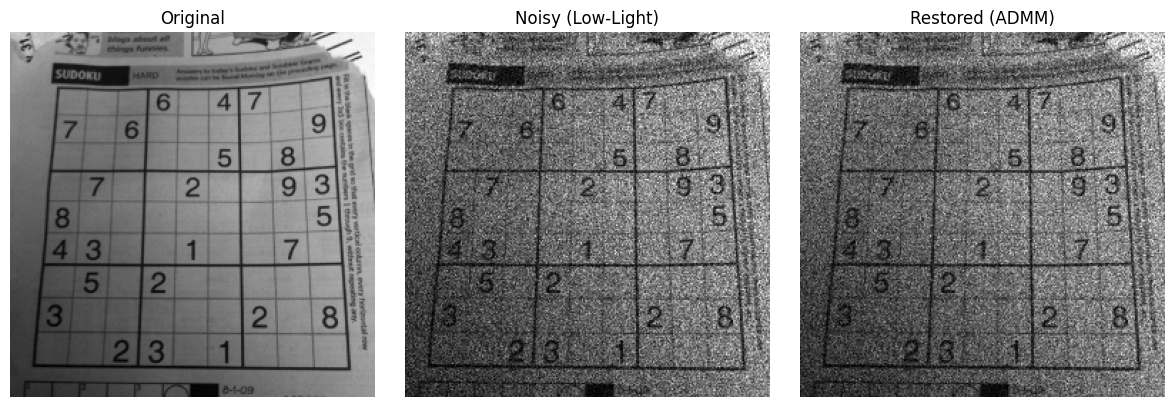

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. Cargar la imagen en escala de grises y normalizar
img = cv2.imread('sudoku.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))  # Redimensionar para estabilidad
img = img.astype(np.float32) / 255.0  # Normalizar entre 0 y 1

# 2. Simular ruido Poisson (low-light)
peak = 30  # Controla intensidad del ruido Poisson
noisy = np.random.poisson(img * peak) / peak
noisy = np.clip(noisy, 0, 1)

# 3. Función de soft-thresholding para los valores singulares
def prox_nuclear(X, tau):
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    S_thresh = np.maximum(S - tau, 0)
    return U @ np.diag(S_thresh) @ Vt

# 4. ADMM con norma nuclear
def admm_nuclear(Y, lambd=0.1, rho=1.0, max_iter=100):
    X = np.copy(Y)
    Z = np.copy(Y)
    U = np.zeros_like(Y)

    for i in range(max_iter):
        # x-update
        X = (Y + rho * (Z - U)) / (1 + rho)

        # z-update (prox. nuclear)
        Z = prox_nuclear(X + U, lambd / rho)

        # u-update (dual)
        U = U + X - Z

    return Z

# 5. Restaurar imagen
restored = admm_nuclear(noisy, lambd=0.1, rho=1.0, max_iter=100)

# 6. Mostrar resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Noisy (Low-Light)')
plt.imshow(noisy, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Restored (ADMM)')
plt.imshow(restored, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


---

### 6. Métricas de Evaluación

Para evaluar la calidad de la restauración de la imagen, se utilizan las siguientes métricas:

#### a) PSNR (Peak Signal-to-Noise Ratio)

Mide la relación entre la potencia máxima de la señal y el ruido que afecta a su representación. Una mayor PSNR indica mejor calidad.

$$
\text{PSNR} = 10 \cdot \log_{10} \left( \frac{MAX_I^2}{\text{MSE}} \right)
$$

Donde:
- $MAX_I$ es el valor máximo posible de un píxel (255 para imágenes de 8 bits).
- MSE es el error cuadrático medio entre la imagen original $x$ y la restaurada $\hat{x}$:
$$
\text{MSE} = \frac{1}{mn} \sum_{i=1}^{m} \sum_{j=1}^{n} \left( x_{ij} - \hat{x}_{ij} \right)^2
$$

#### b) SSIM (Structural Similarity Index)

Mide la similitud estructural entre dos imágenes considerando luminancia, contraste y estructura.

$$
\text{SSIM}(x, \hat{x}) = \frac{(2\mu_x\mu_{\hat{x}} + C_1)(2\sigma_{x\hat{x}} + C_2)}{(\mu_x^2 + \mu_{\hat{x}}^2 + C_1)(\sigma_x^2 + \sigma_{\hat{x}}^2 + C_2)}
$$

Donde:
- $\mu_x$, $\mu_{\hat{x}}$ son las medias locales.
- $\sigma_x^2$, $\sigma_{\hat{x}}^2$ son las varianzas.
- $\sigma_{x\hat{x}}$ es la covarianza entre $x$ y $\hat{x}$.

Valores de SSIM cercanos a 1 indican alta similitud.

#### c) RMSE (Root Mean Square Error)

Mide el error promedio entre la imagen original y la restaurada:

$$
\text{RMSE} = \sqrt{ \frac{1}{mn} \sum_{i=1}^{m} \sum_{j=1}^{n} \left( x_{ij} - \hat{x}_{ij} \right)^2 }
$$

Un valor más bajo de RMSE indica menor error de restauración.

---

Estas métricas permiten comparar objetivamente el desempeño del algoritmo de restauración ADMM en presencia de ruido tipo Poisson bajo condiciones de baja iluminación.


In [14]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from math import sqrt

# Función para calcular las métricas
def compute_metrics(original, noisy, restored):
    # Asegúrate de que todo esté en float64
    original = original.astype(np.float64)
    noisy = noisy.astype(np.float64)
    restored = restored.astype(np.float64)

    # PSNR
    psnr_noisy = peak_signal_noise_ratio(original, noisy, data_range=1.0)
    psnr_restored = peak_signal_noise_ratio(original, restored, data_range=1.0)

    # SSIM
    ssim_noisy = structural_similarity(original, noisy, data_range=1.0)
    ssim_restored = structural_similarity(original, restored, data_range=1.0)

    # RMSE
    rmse_noisy = np.sqrt(np.mean((original - noisy) ** 2))
    rmse_restored = np.sqrt(np.mean((original - restored) ** 2))

    # Mostrar
    print("----- MÉTRICAS DE EVALUACIÓN -----")
    print(f"PSNR (Noisy):     {psnr_noisy:.2f} dB")
    print(f"PSNR (Restored):  {psnr_restored:.2f} dB")
    print(f"SSIM (Noisy):     {ssim_noisy:.4f}")
    print(f"SSIM (Restored):  {ssim_restored:.4f}")
    print(f"RMSE (Noisy):     {rmse_noisy:.4f}")
    print(f"RMSE (Restored):  {rmse_restored:.4f}")

# Llamar a la función
compute_metrics(img, noisy, restored)


----- MÉTRICAS DE EVALUACIÓN -----
PSNR (Noisy):     18.78 dB
PSNR (Restored):  19.14 dB
SSIM (Noisy):     0.3554
SSIM (Restored):  0.3667
RMSE (Noisy):     0.1151
RMSE (Restored):  0.1104
